In [38]:
import pandas, os, json, pymongo, numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import warnings
from sklearn import svm
from IPython.display import clear_output
from scipy import stats
import h5py
import pickle

In [39]:
warnings.filterwarnings('ignore')

In [40]:
%matplotlib inline

In [41]:
def establish_mongo_connection(location, keyname, mongo_database, mongo_collection): 
    """
    connect to database. Requires a connection to server was established via terminal, e.g.
    $ ssh -fNL 27017:localhost:27017 tyler@stanfordmemorylab.com
    """
    # load information from credentials
    access_info = json.load(open(location + keyname))
    # set up the 'tunnel' we'll be using to access the server
    mongo_tunnel = 'mongodb://' + access_info['user'] + ':' + access_info['pwd'] + '@127.0.0.1'
    # conect to the mongo client on the server
    connection = pymongo.MongoClient(mongo_tunnel)
    # connect to the database
    data_base = connection[mongo_database]
    # connect to the collection
    collection = data_base[mongo_collection]
    
    return collection

In [42]:
# credential location 
credential_location = '../credentials/'
# aws key name 
aws_rootkey = 'aws_keys.json'
# mongo key name
mongo_keys = 'mongo_keys'
# name of mongo database to look through
# mongo_database = 'oddity'
# # name of mongo collection
# mongo_collection = 'objectome'
# # 
# iteration = 'third_pilot'
# 
exclude = ['NONE', 'A33F2FVAMGJDGG']

In [43]:
if 0: 
    access_info = json.load(open(credential_location + mongo_keys))
    # set up the 'tunnel' we'll be using to access the server
    mongo_tunnel = 'mongodb://' + access_info['user'] + ':' + access_info['pwd'] + '@127.0.0.1'
    # conect to the mongo client on the server
    connection = pymongo.MongoClient(mongo_tunnel)

    for d in [i for i in connection.database_names() if i not in ['admin', 'config']]: 

        for c in connection[d].collection_names(): 

            n = len( connection[d][c].find({'trial_type':'summary'}).distinct('worker_id') ) 
            print('database:', d, 'collection:', c, 'n:', n)

In [44]:
mongo_database = 'oddity'
mongo_collection = 'lesion'

In [45]:
load_from_server = 0 

if load_from_server:
    
    collection = establish_mongo_connection(credential_location, mongo_keys, mongo_database, mongo_collection)
    # etract the worker ideas that aren't tyler :) 
    worker_ids = [i for i in collection.find({'trial_type':'summary'}).distinct('worker_id') if i not in exclude]
    
    # i'm using this in the dataframe just to avoid printing worker ideas on the repo 
    worker_map = {worker_ids[i]:int(i) for i in range(len(worker_ids))}
    
    print('we\'ve finished collecting data from %d subjects'%len(worker_ids))
    # initialize the data frame to store trial-level results into
    trials = pandas.DataFrame() 

    # iteratre across workers
    for i_worker in worker_ids: 

        print(i_worker)

        # extract a single workers' data 
        pilot = collection.find({'worker_id': i_worker, 'trial_type': 'experiment'})

        # iterate across trials for this subject
        for i_trial_number in range(pilot.count()): 

            i_trial = pilot[i_trial_number]

            if i_trial['timed_out'] == False: 

                trial_indices_ = i_trial['typical_indices'] 
                trial_indices_.extend([i_trial['oddity_index']])

                # just a few things that seem relevant for troubleshooting
                trial_info = {
                    'typical_category': i_trial['typical_category'], 
                    'oddity_category': i_trial['oddity_category'], 
                    'typical_name': i_trial['typical_name'], 
                    'oddity_name': i_trial['oddity_name'], 
                    'chosen_object': i_trial['choice_object'], 
                    'array_type': i_trial['array_type'], 
                    'correct': i_trial['correct'],
                    'reaction_time': i_trial['rt'], 
                    'variation_level': i_trial['variation_level'], 
                    'typical_category': i_trial['typical_category'],
                    'oddity_category': i_trial['oddity_category'],
                    'worker_id': worker_map[i_worker], 
                    'trial_number': i_trial_number, 
                    'oddity_type': i_trial['oddity_type'], 
                    'trial_indices': np.sort( trial_indices_ ), 
                    'iteration': i_trial['iteration']
                    }

                # append this trial's data to the dataframe 
                trials = trials.append(trial_info, ignore_index=True)

    trials.to_pickle('raw_behavior.pickle')
    
else: 
    
    trials = pandas.read_pickle('raw_behavior.pickle')

In [46]:
cutoff = .80

In [47]:
len( trials['worker_id'].unique() ), len(trials)  

(345, 42113)

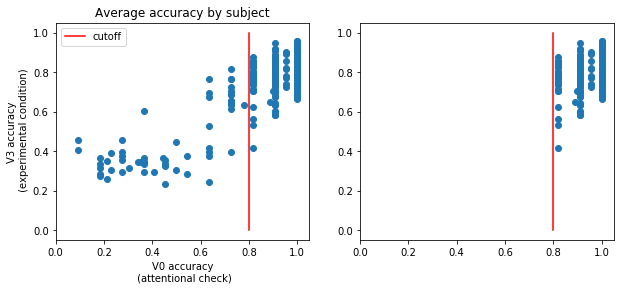

In [48]:
v0=[trials[(trials.worker_id==i) * (trials.variation_level=='V0')].correct.mean() for i in trials.worker_id.unique()]
v3=[trials[(trials.worker_id==i) * (trials.variation_level=='V3')].correct.mean() for i in trials.worker_id.unique()]

plt.figure(figsize=[10, 4])
plt.subplot(121)
plt.scatter(x=v0, y=v3)
plt.title('Average accuracy by subject')
plt.xlabel('V0 accuracy\n (attentional check)')
plt.ylabel('V3 accuracy\n (experimental condition)')
plt.plot([cutoff, cutoff], [0, 1], color='red', label='cutoff')
plt.legend() 
plt.xlim([0,1.05])
keep_subjects = [] 

for i_subject in trials.worker_id.unique(): 
    
    v0_ = trials[(trials.worker_id==i_subject) * (trials.variation_level=='V0') ].correct.mean()
    v3_ = trials[(trials.worker_id==i_subject) * (trials.variation_level=='V3') ].correct.mean() 
    
    if v0_ > cutoff: 
        keep_subjects.append(i_subject)

plt.subplot(122)
v0=[trials[(trials.worker_id==i) * (trials.variation_level=='V0')].correct.mean() for i in keep_subjects]
v3=[trials[(trials.worker_id==i) * (trials.variation_level=='V3')].correct.mean() for i in keep_subjects]
plt.scatter(x=v0, y=v3)
plt.xlim([0,1.05])
plt.plot([cutoff, cutoff], [0, 1], color='red', label='cutoff'); 

In [49]:
trials = trials[[i in keep_subjects for i in trials.worker_id.values ]]
trials = trials[trials.variation_level=='V3']

In [50]:
order = ['animals', 'chairs', 'planes', 'faces']
object_names = [n for c in order for n in np.sort( trials[trials.typical_category==c].typical_name.unique()) ]

In [51]:
len(trials.worker_id.unique()) 

285

In [52]:
# load our dataset
data = h5py.File('/Users/biota/work/perirhinal_cortex/analysis/yamins_2014/ventral_neural_data.hdf5', 'r')

# extract some meta data that we'll be using a lot 
category_names = np.unique(data['image_meta']['category'])
category_labels = np.array(data['image_meta']['category'])
object_labels = np.array(data['image_meta']['object_name'])

data.close() 

In [53]:
all_indices = [] 
i_marker = 0
markers = {} 

for typical_object in object_names: 
    
    oddities = np.sort( trials[trials.typical_name==typical_object]['oddity_name'].unique())
    
    for oddity_object in oddities: 
        
        unique_indices = []

        ij_condition = (trials.typical_name==typical_object) * ( trials.oddity_name==oddity_object)
        i_trial_indices = np.array( [i for i in trials[ij_condition].trial_indices.values] ) 
        

        for i_trial in i_trial_indices: 
            
            # if the list is empty or it doesn't have this trial yet
            if len(unique_indices)==0 or not len( np.nonzero( (i_trial == unique_indices).sum(1) == 3 )[0] ):
                
                unique_indices.append( i_trial )
                
                
                indexed_names = [object_labels[i].decode() for i in i_trial]
                oddity_index = np.nonzero(np.array(indexed_names)==oddity_object)[0][0]
                
                markers[i_marker] = {'indices': i_trial,
                                     'index_names': indexed_names, 
                                     'typical_name': typical_object,
                                     'oddity_name': oddity_object, 
                                     'oddity_index': oddity_index, 
                                     'variation_level':'V3', 
                                     'category': trials['typical_category'][ij_condition].values[0], 
                                     'marker':i_marker, 
                                    } ; i_marker += 1 
                                             
        all_indices.extend( unique_indices )

all_indices = np.array(all_indices) 

In [54]:
# find and label unique markers :) 

In [55]:
mv = [np.nonzero( ((trials['trial_indices'][i] == all_indices).sum(1)) ==3)[0][0] for i in  trials.index.values]
trials['marker'] = mv

In [56]:
# # stimulus metadata for five human validated trials from ANIMALS,CHAIRS, FACES, and PLANES HVM categories 
# with open('ACFP5_stimulimetadata.pickle', 'wb') as handle: 
#     pickle.dump(markers, handle)
    
# trials.to_csv('ACFP5_trial_behavior.csv')
# #/Users/biota/work/perirhinal_cortex/tasks/analysis/ACFP5_stimulimetadata.pickle

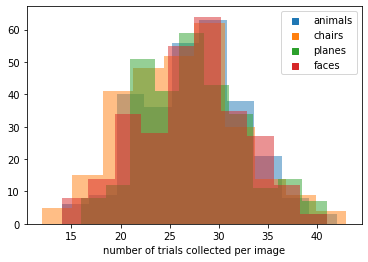

In [57]:
categories = np.sort(trials.typical_category.unique())

for c in order: 
    
    marker_counts =  [len(trials[trials.marker==i]) for i in trials[trials.typical_category==c].marker.unique()]
    plt.hist( marker_counts ,alpha=.5)
    plt.scatter([], [], marker=',', label=c)

plt.legend() 
plt.xlabel('number of trials collected per image'); 

In [58]:
def select_images(data, minimum=.75): 
    
    plt.figure(figsize=[20, 4]); i = 1

    categories = np.sort(trials.typical_category.unique())

    select_markers = [] 

    for c in categories: 

        other_means = data[data.typical_category!=c].correct.mean()
        other_rts = data[data.typical_category!=c].reaction_time.mean()

        plt.subplot(1,4,i); 
        for t in np.sort( trials[trials.typical_category==c]['typical_name'].unique() ): 

            oddities = np.sort( trials[trials.typical_name==t].oddity_name.unique())

            for i_oddity in oddities: 

                MS, RTs = [], []

                pair_markers = data[( data.typical_name==t ) * (data.oddity_name==i_oddity)].marker.unique()

                for i_marker in  pair_markers: 

                    ms  = data[data.marker==i_marker]['correct'].mean()
                    rts = data[data.marker==i_marker]['reaction_time'].mean()

                    plt.scatter(x=rts,y=ms, color='grey', s=10)

                    MS.append(ms)
                    RTs.append(rts)

                best_index = np.argmin(np.abs(np.array(MS)- other_means)) 

                if MS[best_index] > minimum: 
                    select_markers.append( pair_markers[ best_index ] ) 
                    plt.scatter(x=RTs[best_index], y=MS[best_index],  edgecolor='red', alpha=1, facecolor='none', )

        plt.scatter(x=[], y=[], edgecolor='red', alpha=1, facecolor='none', label='Selected Pair') 
        plt.legend(loc=3) 
        plt.ylim(-.05, 1.05)
        plt.xlim(1100, 4700)
        plt.title(c)
        if i == 1: plt.ylabel('accuracy'); 
        plt.xlabel('reaction time (ms)')    
        i+=1

    select_markers = np.array(select_markers)

    return select_markers

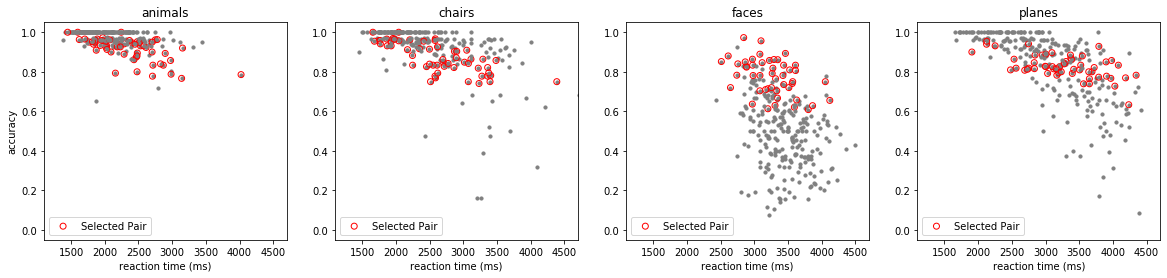

In [59]:
select_markers = select_images(trials, minimum=.6) 

In [60]:
subset = trials[[i in select_markers  for i in trials['marker']]]

In [61]:
subjects = subset.worker_id.unique() 

In [62]:
def show_things(subset):  
    cs = ['C0', 'C1', 'C2', 'C3']
    cs = {categories[i]: cs[i] for i in range(len(categories))}

    Xc, Yc = [] , [] 
    plt.figure(figsize=[15, 4])
    plt.subplot(131)
    Ms, RTs = {}, {} 
    for t in np.sort(subset.typical_category.unique()): 

        Ms[t], RTs[t] = [], [] 

        for i_subject in list(subset.worker_id.unique())[0:10]: 

            i_data = subset[subset.worker_id==i_subject]
            ms  = i_data[(i_data.typical_category==t)]['correct'].mean()
            rts = i_data[(i_data.typical_category==t)]['reaction_time'].mean() 

            Ms[t].extend( [ ms ])
            RTs[t].extend( [ rts ])

        plt.scatter(x=np.mean(RTs[t]),y=np.mean(Ms[t]),  color=cs[t])

        Xc.append( np.mean(RTs[t]) )
        Yc.append( np.mean(Ms[t]) )

        plt.errorbar(x=np.mean(RTs[t]), 
                     y=np.mean(Ms[t]),
                     yerr = np.std(Ms[t]), 
                     xerr= np.std(RTs[t]), 
                     color=cs[t], alpha=.5, 
                     barsabove=True)


    plt.title( 'category-level relationship' )
    plt.ylim(0.28, 1.02)
    plt.plot([2000, 4000], [1/3, 1/3], color='grey', linestyle=':'); 

    #plt.legend(loc=3, title='Category'); 

    Xo, Yo = [] , [] 
    plt.xlabel('reaction time (ms)')
    plt.ylabel('accuracy'); 

    ########################################
    plt.subplot(132)

    for t in np.sort(subset.typical_category.unique()): 

        typicals = np.sort( subset[subset.typical_category==t]['typical_name'].unique())

        ms  = [subset[(subset.typical_category==t)*(subset.typical_name==o)]['correct'].mean() for o in typicals]
        rts = [subset[(subset.typical_category==t)*(subset.typical_name==o)]['reaction_time'].mean() for o in typicals]

        Yo.extend( ms )
        Xo.extend( rts )
        plt.scatter(x=rts,y=ms, label=t, color=cs[t])

    plt.title( 'object-level relationship r = %.02f'%np.corrcoef( Xo , Yo)[0, 1] )
    plt.ylim(0.28, 1.02)
    plt.plot([min(Xo), max(Xo)], [1/3, 1/3], color='grey', linestyle=':'); 
    plt.legend(loc=3, title='Category'); 
    plt.xlabel('reaction time (ms)')

    ########################################

    plt.subplot(133) 
    i = 1

    
    Xi, Yi = [], [] 
    for c in categories: 

        for t in np.sort( subset[subset.typical_category==c]['typical_name'].unique() ): 

            oddities = np.sort( subset[subset.typical_name==t].oddity_name.unique())

            ms  = [subset[(subset.typical_name==t)*(subset.oddity_name==o)]['correct'].mean() for o in oddities]
            rts = [subset[(subset.typical_name==t)*(subset.oddity_name==o)]['reaction_time'].mean() for o in oddities]

            plt.scatter(x=rts,y=ms, color=cs[c],alpha=1)

            Xi.extend(rts)
            Yi.extend(ms)

        plt.scatter(x=[],y=[], label=c, color=cs[c])

    plt.ylim(0.28, 1.02)
    plt.legend(loc=3, title='Category')
    plt.xlabel('reaction time (ms)')
    plt.ylabel('accuracy')
    plt.title( 'image-level relationship r = %.02f'%np.corrcoef( Xi, Yi )[0, 1] ); 
    plt.plot([min(Xi), max(Xi)], [1/3, 1/3], color='grey', linestyle=':'); 
    plt.savefig('/Users/biota/Desktop/scratch/behavior_multilevel_rt-accuracy_correlation.pdf')
    
    return Xc, Yc, Xo, Yo, Xi, Yi

Text(0.5, 1.05, 'unfiltered data')

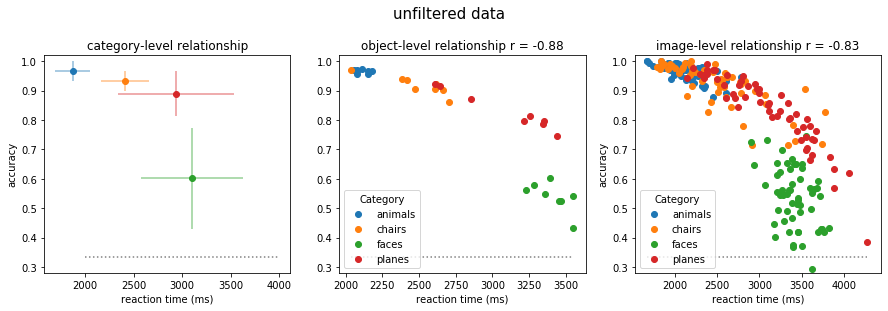

In [63]:
Xc, Yc, Xo, Yo, Xi, Yi = show_things(trials)
plt.suptitle('unfiltered data', y=1.05, fontsize=15)

Text(0.5, 1.05, 'filtered data')

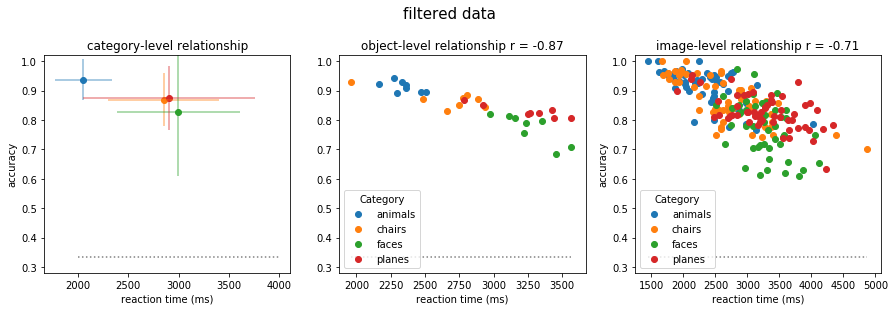

In [64]:
Xc, Yc, Xo, Yo, Xi, Yi = show_things(subset)
plt.suptitle('filtered data', y=1.05, fontsize=15)

In [96]:
def create_dataframe(d, m): 
    
    markers = [i for i in d.marker.unique() if i in list( m ) ]#np.sort( d.marker.unique() )
    _acc = [d[d.marker==m].correct.mean() for m in markers]
    _rt  = [d[d.marker==m].reaction_time.mean() for m in markers]
    _tn  = [[i for i in d[d.marker==m].typical_name][0] for m in markers]
    _on  = [[i for i in d[d.marker==m].oddity_name][0] for m in markers]
    _cat = [[i for i in d[d.marker==m].typical_category][0] for m in markers]
    
    _it  = [np.mean( m[i]['it'] ) for i in markers]
    _v4  = [np.mean( m[i]['v4'] ) for i in markers]
    _p3  = [np.mean( m[i]['pool3'] ) for i in markers]
    _p4  = [np.mean( m[i]['pool4'] ) for i in markers]
    _p5  = [np.mean( m[i]['pool5'] ) for i in markers]
    _fc6 = [np.mean( m[i]['fc6'] ) for i in markers]
    _fc7 = [np.mean( m[i]['fc7'] ) for i in markers]
    _fc8 = [np.mean( m[i]['fc8'] ) for i in markers]
    _ch  = [( m[i]['metadata']['typical_name'], m[i]['metadata']['oddity_name']) for i in markers]
    
    df = pandas.DataFrame({'human':_acc, 'rt':_rt, 'typical_name':_tn, 'oddity_name':_on, 'category':_cat, 
                           'it': _it, 'v4':_v4, 
                           'pool3':_p3, 'pool4':_p3, 'pool5':_p3, 'fc6':_fc6, 'fc7':_fc7, 'fc8':_fc8, 
                           'check':_ch,'marker': markers})
    
    
    df['delta_it_v4'] = df['it']-df['v4'] 
    df['delta_prc_it'] = df['human']-df['it'] 
    df['delta_fc6_v4'] = df['fc6']-df['v4'] 
    df['delta_prc_fc6'] = df['human']-df['fc6'] 
    df['delta_prc_v4'] = df['human']-df['v4'] 

    return df 

In [97]:
# was ~/work/perirhinal_cortex/tasks/analysis/neural_HVM-oddity_predictions.pickle
with open('electrophysiological_oddity_predictions.pickle', 'rb') as handle: 
    neural_predictions = pickle.load(handle)

# was ~/work/perirhinal_cortex/tasks/analysis/model_predictions_pool3-5-fc-layers.pickle
with open('model_oddity_predictions.pickle', 'rb') as handle: 
    model_predictions = pickle.load(handle)

In [98]:
subset_df = create_dataframe(subset, model_predictions)

In [99]:
pandas.DataFrame.to_csv(subset_df, '../../human_performance.csv') 

In [105]:
_df = subset_df
_names = _df.typical_name.unique()
novel_summary = pandas.DataFrame({
    'it': np.array([_df[_df.typical_name==o]['it'].mean() for o in _names]), 
    'v4': np.array([_df[_df.typical_name==o]['v4'].mean() for o in _names]),
    'fc6': np.array([_df[_df.typical_name==o]['fc6'].mean() for o in _names]),
    'prc': np.array([_df[_df.typical_name==o]['human'].mean() for o in _names]),
    'rt': np.array([np.round(_df[_df.typical_name==o]['rt'].mean()) for o in _names]), 
    'object': np.array([o for o in _names]),
    'category': [_df[_df.typical_name==o]['category'].iloc[0] for o in _names]
})

novel_summary['delta_prc_it'] = novel_summary['prc'] - novel_summary['it']
novel_summary['delta_prc_v4'] = novel_summary['prc'] - novel_summary['v4']

In [106]:
pandas.DataFrame.to_csv(novel_summary, '../../summary_dataframe.csv') 

In [90]:
def generate_shuffled_indices(n): 
    z = np.zeros(len(n)) ; 
    z[int(len(z)/2):] = 1 ; 
    z = np.random.permutation(z)
    return z

def zscore(v): 
    return (v - np.mean(v)) / np.std(v)

def extract_off_diagonal(m): 
    return (np.array([m.flatten()[i] for i in range(len(m.flatten())) if i%9 !=0]))

def extract_diagonal(m): 
    accuracy = np.array(np.array(m).flatten()[np.nonzero(np.eye(m.shape[0]).flatten())[0]])
    return (accuracy)

In [69]:
def reliability_analysis(trials, level, n_iterations=100, z_score=0): 
    
    distributions = {'correct':[], 'null_correct':[], 'reaction_time':[], 'null_reaction_time':[]}

    z = z_score
    
    i_level = {'category':'typical_category','object':'typical_name', 'image':'marker'}[ level ]
        
    if level=='category': 
        plt.figure(figsize=[10, 4])
    elif level=='object': 
        plt.figure(figsize=[20, 4])
    elif level=='image': 
        plt.figure(figsize=[20, 8])

    for i_iteration in range(n_iterations): 

        A, B = {'correct':[], 'reaction_time':[]}, {'correct':[], 'reaction_time':[]}

        for i_category in trials.typical_category.unique(): 

            trial_data = trials[trials.typical_category==i_category]
            random_trials = generate_shuffled_indices(trial_data)

            a = trial_data.loc[random_trials==0]
            b = trial_data.loc[random_trials==1]

            for i_type in ['correct', 'reaction_time']: 

                a_ = [a[a[i_level]==i][i_type].mean() for i in np.sort(trial_data[i_level].unique())]  
                b_ = [b[b[i_level]==i][i_type].mean() for i in np.sort(trial_data[i_level].unique())] 

                if z: 
                    a_ =  zscore( a_ )
                    b_ =  zscore( b_ )

                A[i_type].extend( [i for i in a_ if a_ == a_])
                B[i_type].extend( [i for i in b_ if b_ == b_] ) 

        for i_type in ['correct', 'reaction_time']:     

            r_ = np.corrcoef( A[i_type]  ,  B[i_type] )[0,1]
            r_null_ = np.corrcoef(A[i_type], np.random.permutation(B[i_type]))[0,1]

            distributions[i_type].append(r_)
            distributions['null_%s'%i_type].append(r_null_)
            if i_iteration % (n_iterations//10) == 0: 
                if i_level == 'marker': 
                    plt.subplot(2,1,{'reaction_time':2, 'correct':1}[i_type])
                else: 
                    plt.subplot(1,2,{'reaction_time':2, 'correct':1}[i_type])
                plt.plot( A[i_type] , color='blue', linestyle=':', alpha=1, linewidth=.5) 
                plt.plot( B[i_type] , color='red', linestyle='--', alpha=1, linewidth=.5)

    for i in [1,2]: 

        i_type = ['correct', 'reaction_time'][i-1]
        if i_level == 'marker': 
            plt.subplot(2,1,i)
        else: 
            plt.subplot(1,2,i)
        plt.plot( [], color='blue', linestyle=':', alpha=1, linewidth=.5, label='half 1') 
        plt.plot( [], color='red', linestyle='--', alpha=1, linewidth=.5, label='half 2')
        
        plt.title( '%s Split-half %s \n( r  = %.02f +- %.02f, p < %.02e)'
                  %(level, i_type, 
                    np.mean( distributions[i_type]), np.std( distributions[i_type]), 
                    np.mean(r_null_>np.mean( distributions[i_type]))
                   ), y=1.1, fontsize=12); 
        if i==1: plt.legend() 
        plt.ylabel(i_type)
        if level=='category': 
            ns = [c.upper() for c in trials.typical_category.unique()]
            plt.xticks(range(len(ns)), ns)
        elif level=='object': 
            ns = [o for c in trials.typical_category.unique() for o in  trials[trials.typical_category==c].typical_name.unique()]
            plt.xticks(range(4, len(ns), 8), [c for c in trials.typical_category.unique()])
        elif level=='image': 
            plt.xticks([])
    
    return distributions

In [70]:
reliability = {} 

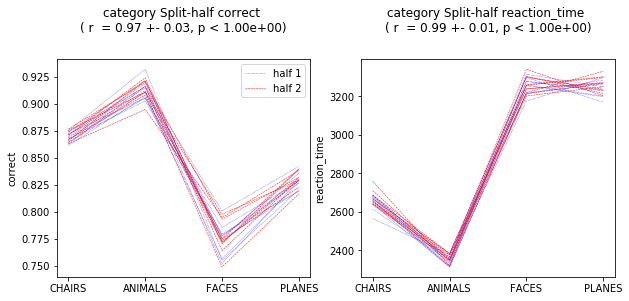

In [34]:
reliability['category'] = reliability_analysis(subset, 'category', n_iterations=100)

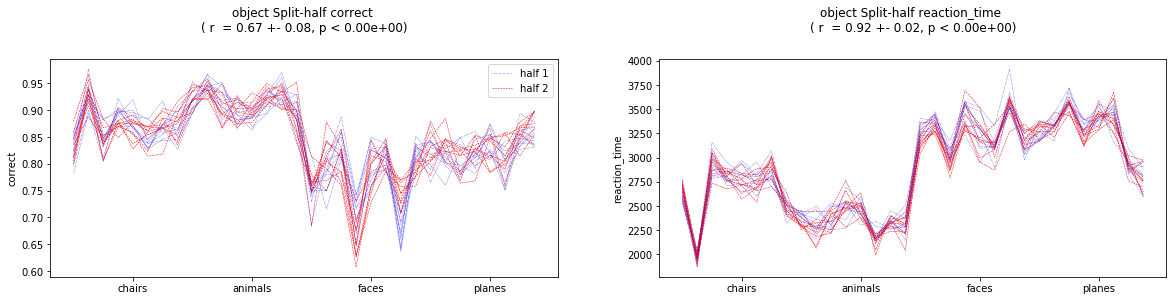

In [41]:
reliability['object'] = reliability_analysis(subset, 'object', n_iterations=100)

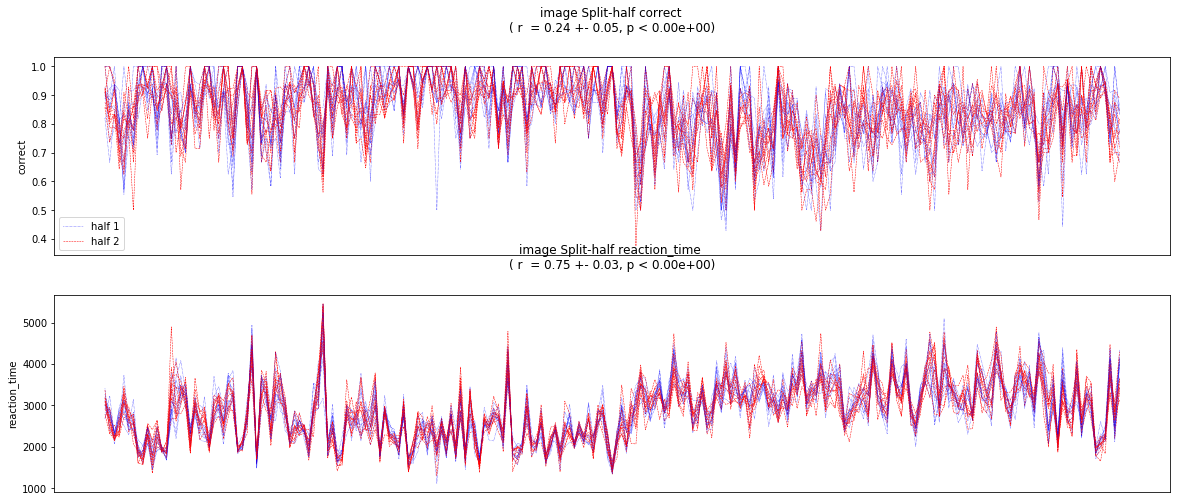

In [50]:
reliability['image'] = reliability_analysis(subset, 'image', n_iterations=100)

In [ ]:
def reliability_distributions(i_data, i_subset, i_type,): 
    plt.hist(i_data[i_subset][i_type], alpha=.4, bins=25, label=i_subset) 
    plt.xlim(0, 1.05)
plt.figure(figsize=[10, 4])
plt.subplot(121)
reliability_distributions(reliability, 'category', 'correct',) 
reliability_distributions(reliability, 'object', 'correct', ) 
reliability_distributions(reliability, 'image', 'correct', ) 
plt.title('accuracy reliability')
plt.legend() 
plt.subplot(122)
reliability_distributions(reliability, 'category', 'reaction_time', ) 
reliability_distributions(reliability, 'object', 'reaction_time', ) 
reliability_distributions(reliability, 'image', 'reaction_time', ) 
plt.title('reaction time reliability')
plt.legend() 